# **IMPORTS**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB4
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import datasets, Input, Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, GlobalAveragePooling2D

```
⠀⠀⠀⠀⠀⠀⣀⣤⡤
⠀⠀⠀⠀⢀⣾⣿⠋
⠀⠀⠀⣠⣾⣿⡟
⠀⠀⢸⠛⠉⢹⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠄⠠⣀
⠀⠀⡘⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠖⠉⠀⠀⠀⣾⣿⣦⡀
⠀⠀⡇⠀⠀⠀⢡⠄⠀⠀⣀⣀⣀⣠⠊⠀⠀⠀⠀⡠⠞⠛⠛⠛⠛⡀
⠀⠀⢃⠀⠀⠀⠀⠗⠚⠉⠉⠀⠈⠁⠀⠀⠀⢀⡔⠁⠀
⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣶⣄⠲⡎
⠀⠀⠀⠃⠀⠀⢠⣤⡀⠀⠀⠀⠀⣿⣿⣿⠀⠘⡄
⠀⠀⠀⡆⠀⠀⣿⣿⡇⠀⠀⠀⠀⠈⠛⠉⣴⣆⢹⡄
⠀⠀⠀⣇⢰⡧⣉⡉⠀⠀⢀⡀⠀⣀⣀⣠⣿⡷⢠⡇
⠀⠀⠀⢻⠘⠃⠈⠻⢦⠞⠋⠙⠺⠋⠉⠉⠉⢡⠟
⠀⠀⠀⠀⠳⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠋⠀⠀
```

# **SETTINGS**
---

In [4]:
# Activates XLA (for JIT compiler)
os.environ["TF_XLA_FLAGS"]= "--tf_xla_enable_xla_devices"

# Uses the right memory when using GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"

# **DATA**

---

In [5]:
# Loading CIFAR-10
data= datasets.cifar10.load_data()

In [6]:
# Spliting the data from the Dataset
(X_train, y_train), (X_test, y_test)= data

In [7]:
print(f"Shape of X-train: {X_train.shape}\nShape of X-test: {X_test.shape}")
print(f"Shape of y-train: {y_train.shape}\nShape of y-test: {y_test.shape}")

Shape of X-train: (50000, 32, 32, 3)
Shape of X-test: (10000, 32, 32, 3)
Shape of y-train: (50000, 1)
Shape of y-test: (10000, 1)


In [24]:
class_names= [
  "airplane", "automobile", "bird", "cat",
  "deer", "dog", "frog", "horse", "ship", "truck"
]

/tmp/ipython-input-3158793262.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[idx])])


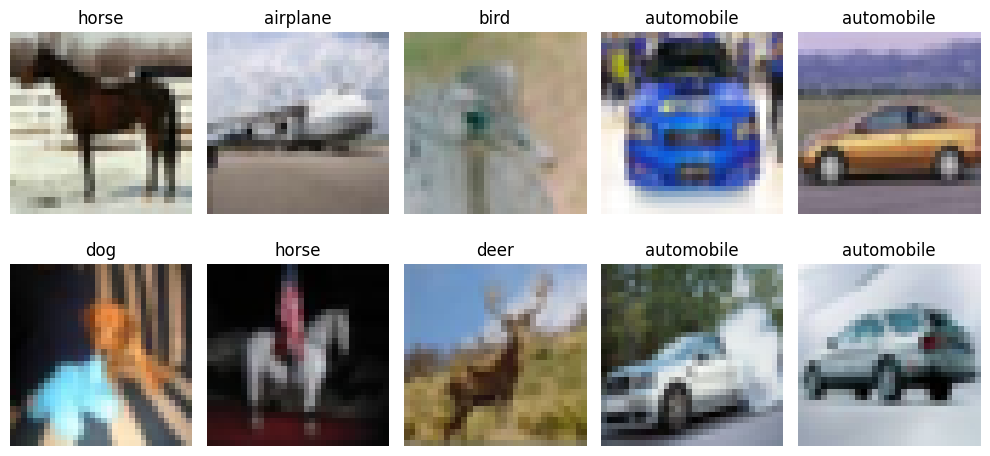

In [9]:
plt.figure(figsize=(10, 5))
# shows random 10 images from dataset
for i in range(10):
  idx= np.random.randint(len(X_train))
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[idx])
  plt.title(class_names[int(y_train[idx])])
  plt.axis("off")

plt.tight_layout()
plt.show()

# **PREPROCESSING DATA**

---

## Functions

In [7]:
def resize_and_preprocess_in_chunks(X, target_size=(64, 64), batch_size=64, dtype=np.float32):
  n_samples= X.shape[0]
  X_resized= np.empty((n_samples, target_size[0], target_size[1], X.shape[-1]), dtype=dtype)

  for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X[i:end]
    batch_resized = tf.image.resize(batch, target_size, method='bilinear')
    batch_resized = preprocess_input(batch_resized.numpy().astype(dtype))
    X_resized[i:end] = batch_resized
    if i % (35 * batch_size) == 0:
      print(f"  → Processed {end}/{n_samples} images...")

  return X_resized

In [8]:
target_size= (158, 158)

In [9]:
# Resize and preprocess X_train (on the same step to save RAM)
X_train_pp= resize_and_preprocess_in_chunks(X_train, target_size= target_size)

  → Processed 64/50000 images...
  → Processed 2304/50000 images...
  → Processed 4544/50000 images...
  → Processed 6784/50000 images...
  → Processed 9024/50000 images...
  → Processed 11264/50000 images...
  → Processed 13504/50000 images...
  → Processed 15744/50000 images...
  → Processed 17984/50000 images...
  → Processed 20224/50000 images...
  → Processed 22464/50000 images...
  → Processed 24704/50000 images...
  → Processed 26944/50000 images...
  → Processed 29184/50000 images...
  → Processed 31424/50000 images...
  → Processed 33664/50000 images...
  → Processed 35904/50000 images...
  → Processed 38144/50000 images...
  → Processed 40384/50000 images...
  → Processed 42624/50000 images...
  → Processed 44864/50000 images...
  → Processed 47104/50000 images...
  → Processed 49344/50000 images...


In [10]:
# Resize and preprocess X_test (on the same step to save RAM)
X_test_pp=  resize_and_preprocess_in_chunks(X_test, target_size= target_size)

  → Processed 64/10000 images...
  → Processed 2304/10000 images...
  → Processed 4544/10000 images...
  → Processed 6784/10000 images...
  → Processed 9024/10000 images...


In [11]:
# Apply OHE to cat data (y)
y_train_cat= to_categorical(y_train, 10)
y_test_cat=  to_categorical(y_test, 10)

/tmp/ipython-input-3239152611.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[idx])])


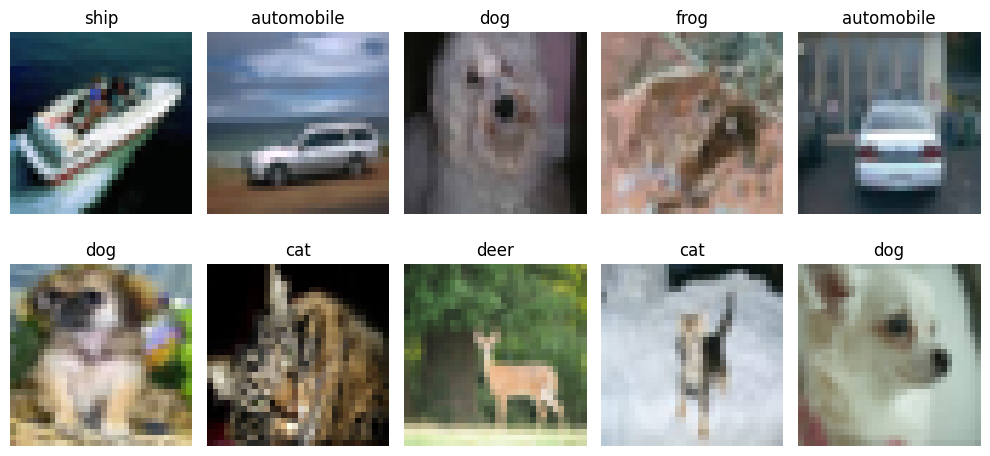

In [ ]:
plt.figure(figsize=(10, 5))
# shows random 10 images from dataset
for i in range(10):
  idx= np.random.randint(len(X_train_pp))
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train_pp[idx])
  plt.title(class_names[int(y_train[idx])])
  plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
localpath= "/content/cifar10_efficientnetb2_preprocessed.npz"
filepath= "/content/drive/MyDrive/cdd_ironhack_p4/"

# saves compressed data (our resized and preprocessed imgs) to local
"""np.savez_compressed(
  localpath,          # 224x224 imgs last a 21GB file and more or less 40 minutes to save on local
  X_train= X_train_pp,
  X_test=  X_test_pp,
  y_train= y_train_cat,
  y_test=  y_test_cat
)"""

'np.savez_compressed(\n  localpath,          # 224x224 imgs last a 21GB file and more or less 40 minutes to save on local\n  X_train= X_train_pp,\n  X_test=  X_test_pp,\n  y_train= y_train_cat,\n  y_test=  y_test_cat\n)'

# **USING EfficientNetB2**

---

**[EfficientNetB2](https://keras.io/api/applications/efficientnet/#efficientnetb2-function)** doesn't expect a shape minimum of the images dimensions, so we can use the native shape `32x32px`, but the issue is *that* the model was trained using `224x224px` images. Naturally, higher resolutions means to a better performance on the model. Reshaping the images to `224x224px` is **so expensive**, and we cannot efford that —we can use `on-the-fly` solution to improve this, but `I` lack the knowladge for this, so, instead, I reshape to `158x158px` and it improves the performance on `±20%` accuracy.

In [12]:
# We load the basemodel B2 and froze it
base_model= EfficientNetB2(input_shape=(158, 158, 3), include_top=False, weights='imagenet')
base_model.trainable= False

In [18]:
# We made our custom top classifier
model= Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(128, activation='relu'),
  Dropout(0.5), # drop half neurons to avoid overfitting on a very dense model (B2)
  Dense(256, activation='relu', kernel_regularizer= l2(0.001)), # Add l2 regularizer
  Dense(10, activation='softmax')
])

In [19]:
# We C O M P I L E !
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# AND WE TRAIN!
history= model.fit(
  X_train_pp, y_train_cat,
  validation_split=0.2,
  epochs=10,
  batch_size=64
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 89ms/step - accuracy: 0.7727 - loss: 0.8744 - val_accuracy: 0.9012 - val_loss: 0.3892
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.8797 - loss: 0.4544 - val_accuracy: 0.9070 - val_loss: 0.3319
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8874 - loss: 0.3844 - val_accuracy: 0.9027 - val_loss: 0.3253
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.8951 - loss: 0.3455 - val_accuracy: 0.9095 - val_loss: 0.2995
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9015 - loss: 0.3210 - val_accuracy: 0.9076 - val_loss: 0.2941
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9061 - loss: 0.3042 - val_accuracy: 0.9126 - val_loss: 0.2960
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9085 - loss: 0.2949 - val_accuracy: 0.9098 - val_loss: 0.2972
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9126 - loss: 0.2808 - 

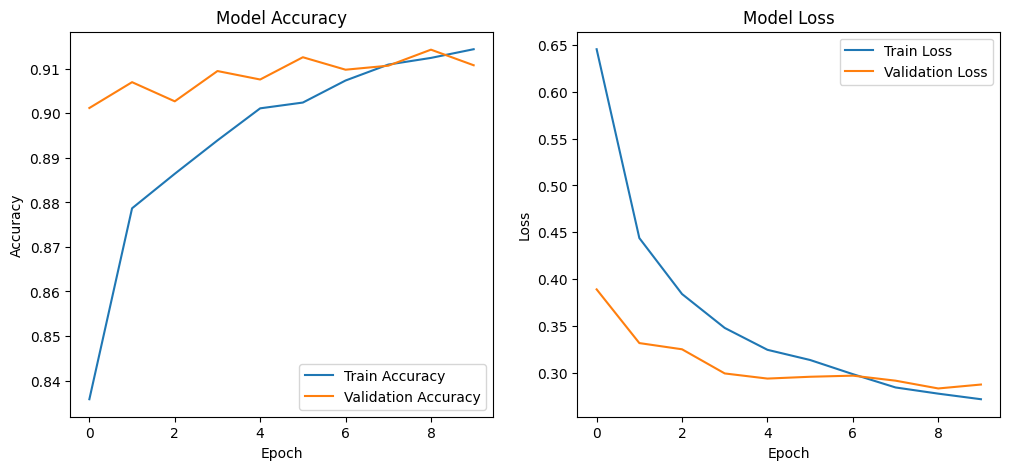

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
# Then, we evaluate the model
test_loss, test_acc= model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8998 - loss: 0.3363
Test Accuracy: 0.9047


In [23]:
# And store its predictions
y_pred_probs = model.predict(X_test_pp)
y_pred= np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step


In [24]:
report= classification_report(y_test, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.93      0.87      0.90      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.90      0.90      0.90      1000
         cat       0.82      0.82      0.82      1000
        deer       0.90      0.90      0.90      1000
         dog       0.86      0.88      0.87      1000
        frog       0.94      0.94      0.94      1000
       horse       0.94      0.92      0.93      1000
        ship       0.94      0.93      0.94      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



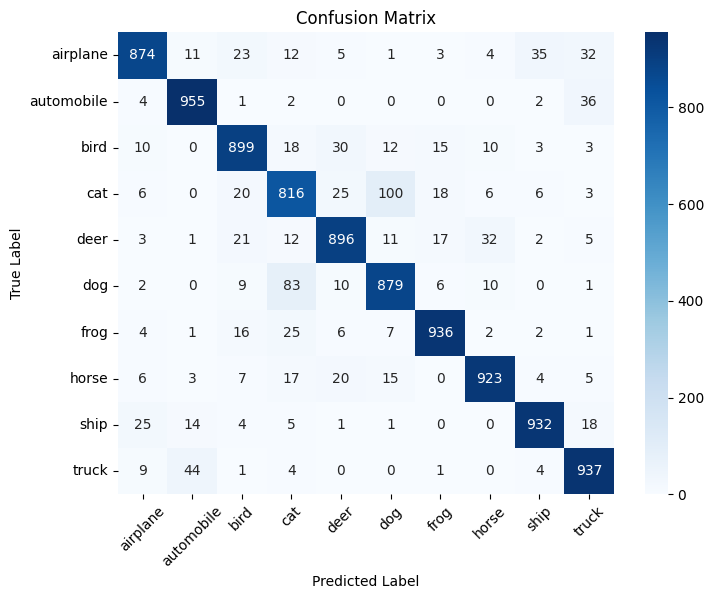

In [ ]:
cm= confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


>Good model but not enough. We have lil' overfit on `train` and some high values on confussion like `cat and dog`.

# **MODEL TUNING**

---

## Unfreezing the last layers

In [13]:
len(base_model.layers)

340

In [ ]:
#  Freeze all layers except the last N layers

base_model.trainable= True                     # unfroze the model
fine_tune_at= len(base_model.layers) - 160     # select the 160 last layers
for layer in base_model.layers[:fine_tune_at]: # kept the last 160 layers to use
  layer.trainable= False                       # froze the model

## Top Classifier

In [16]:
# We made our custom top classifier
model= Sequential([
  base_model,                     # recreate the model (avoids retraining)
  GlobalAveragePooling2D(),       # apply an average pool to 2d layer
  Dense(128, activation='relu'),  # dense layer using ReLU
  Dropout(.2),                    # drop 20% of the prev. dense layer
  Dense(256, activation='relu', kernel_regularizer= l2(.001)), # dense layer using ReLU and l2 regularizer to avoid overfit
  Dense(10, activation='softmax') # output layer using softmax
])

## Model re-compile

In [17]:
# Compile model with a lower learning rate
model.compile(                            # recompile model
  optimizer= Adam(learning_rate= 5e-6),   # using Adam with 5e-6 learning rate
  loss=      'categorical_crossentropy',  # using categorical crossentropy as loss value handler
  metrics=   ['accuracy']                 # focusing accuracy on metrics
)

## Callbacks

In [18]:
# Reduce learning rate when learning doesn't improve
reduce_lr= ReduceLROnPlateau( # reduce learning rate on plateau
  monitor=  "val_loss",       # to reduce val_loss
  factor=   0.5,              # when detects, reduces on 50% the learning rate
  patience= 2,                # every 2 epochs w/o improvement
  min_lr=   1e-8,             # with a minimun 1e-8% learning rate
  verbose=  1                 # verbose
)

In [19]:
# Allows the model to stop early to prevent overfitting
early_stop= EarlyStopping(   # early stopping to avoid overfit
  monitor=    "val_loss",    # to reduce val_loss
  patience=   3,             # stops after 3 epochs w/o improvements
  restore_best_weights=True, # keeps the better model
  min_delta=  1e-5,          # allows "improvement" only if val_loss improves 1e-5 units
  verbose=    1              # verbose
)

In [20]:
savepath= "/content/drive/MyDrive/cdd_ironhack_p4/model_tune_b2.keras"

checkpoint= ModelCheckpoint(
  filepath=   savepath,     # on the save path
  monitor=    "val_loss",   # when the val_loss improves
  save_best_only= True,     # saves it
  mode=       "min",        # what it means the better
  verbose=    1             # verbose
)

## Fine tune

### Best Config Sheet
```batch
select the 160 last layers
dense (128) relu dropout 20%
dense (256) relu kernel l2 .001
output layer softmax

Adam optimizer lr= 5e-6

fine tune epochs  3,
total epochs      15,
validation split  20%,
initial epoch     2.
batch size        128
```

In [21]:
# Continue training (fine-tuning)
fine_tune_epochs= 3
total_epochs=     15 + fine_tune_epochs

history_fine=       model.fit(
  X_train_pp, y_train_cat,
  validation_split=  .2,
  epochs=            total_epochs,
  initial_epoch=     4,
  batch_size=        128,
  callbacks=         [early_stop, reduce_lr, checkpoint],
)

Epoch 5/18
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1331 - loss: 2.4673
Epoch 5: val_loss improved from inf to 2.27625, saving model to /content/drive/MyDrive/cdd_ironhack_p4/model_tune_b2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 206s 387ms/step - accuracy: 0.1333 - loss: 2.4672 - val_accuracy: 0.3847 - val_loss: 2.2763 - learning_rate: 5.0000e-06
Epoch 6/18
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3796 - loss: 2.2276
Epoch 6: val_loss improved from 2.27625 to 1.86114, saving model to /content/drive/MyDrive/cdd_ironhack_p4/model_tune_b2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.3798 - loss: 2.2273 - val_accuracy: 0.6170 - val_loss: 1.8611 - learning_rate: 5.0000e-06
Epoch 7/18
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6042 - loss: 1.7907
Epoch 7: val_loss improved from 1.86114 to 1.31536, saving model to /content/drive/MyDrive/cdd_ironhack_p4/model_tune_b2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.6043

## Metrics

In [22]:
test_loss, test_acc= model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9321 - loss: 0.3747
Test Accuracy after fine-tuning: 0.9361


In [25]:
y_pred_probs= model.predict(X_test_pp)
y_pred= np.argmax(y_pred_probs, axis=1)

report= classification_report(y_test, y_pred, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
              precision    recall  f1-score   support

    airplane       0.94      0.95      0.95      1000
  automobile       0.96      0.97      0.96      1000
        bird       0.94      0.93      0.94      1000
         cat       0.88      0.84      0.86      1000
        deer       0.93      0.94      0.94      1000
         dog       0.88      0.89      0.88      1000
        frog       0.96      0.97      0.96      1000
       horse       0.95      0.95      0.95      1000
        ship       0.96      0.97      0.96      1000
       truck       0.96      0.95      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



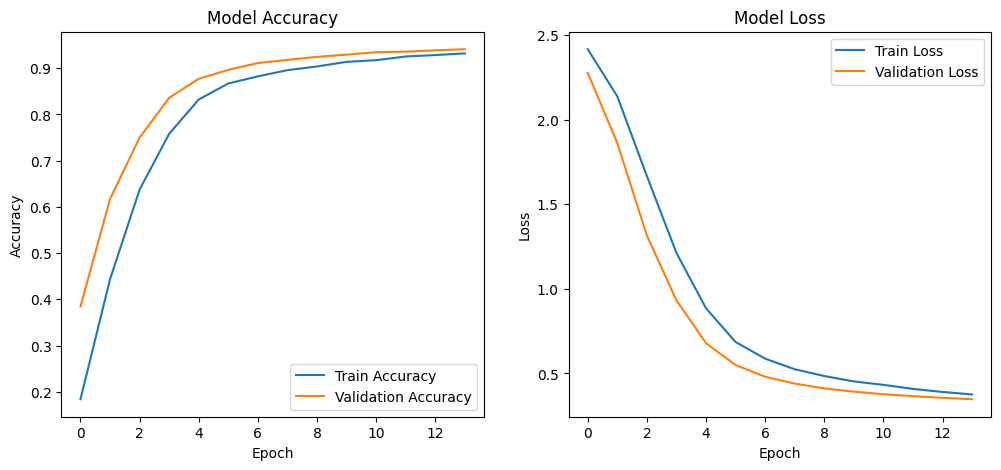

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **USING EfficientNetB4**

---

[EfficientNetB4](https://keras.io/api/applications/efficientnet/#efficientnetb4-function) runs exactly the same as B2 version, but it is better and a little bit more complex. We are gonna use the same preset settings as B2 for B4 and compare it results

In [13]:
# We load the basemodel B4 and froze it
base_model_b4= EfficientNetB4(input_shape=(158, 158, 3), include_top=False, weights='imagenet')
base_model_b4.trainable= False

In [15]:
#  Freeze all layers except the last N layers
base_model_b4.trainable= True                  # unfroze the model
fine_tune_at= len(base_model_b4.layers) - 90   # select the 90 last layers
for layer in base_model_b4.layers[:fine_tune_at]: # kept the last 90 layers to use
  layer.trainable= False                       # froze the model

## Top Classifier

In [16]:
# We made our custom top classifier
model_b4= Sequential([
  base_model_b4,                  # recreate the model (avoids retraining)
  GlobalAveragePooling2D(),       # apply an average pool to 2d layer
  Dense(128, activation='relu'),  # dense layer using ReLU
  Dropout(.3),                    # drop 20% of the prev. dense layer
  Dense(256, activation='relu', kernel_regularizer= l2(0.001)), # dense layer using ReLU and l2 regularizer to avoid overfit
  Dropout(.1),                    # drop 10% of the prev. dense layer
  Dense(10, activation='softmax') # output layer using softmax
])

## Model re-compile and fit

In [17]:
# Compile model with a lower learning rate
model_b4.compile(                         # recompile model
  optimizer= Adam(learning_rate= 3e-6),   # using Adam with 5e-6 learning rate
  loss=      'categorical_crossentropy',  # using categorical crossentropy as loss value handler
  metrics=   ['accuracy']                 # focusing accuracy on metrics
)

In [21]:
# fit fine tuned model
fine_tune_epochs= 3
total_epochs=     10 + fine_tune_epochs

history_fine_b4=     model_b4.fit(
  X_train_pp, y_train_cat,
  validation_split=  .2,
  epochs=            total_epochs,
  initial_epoch=     4,
  batch_size=        64,
  callbacks=         [early_stop, reduce_lr],
)

Epoch 5/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 138ms/step - accuracy: 0.1491 - loss: 2.4422 - val_accuracy: 0.4190 - val_loss: 2.2654 - learning_rate: 3.0000e-06
Epoch 6/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.3845 - loss: 2.2123 - val_accuracy: 0.6878 - val_loss: 1.9409 - learning_rate: 3.0000e-06
Epoch 7/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6220 - loss: 1.8640 - val_accuracy: 0.7875 - val_loss: 1.4707 - learning_rate: 3.0000e-06
Epoch 8/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.7449 - loss: 1.4274 - val_accuracy: 0.8267 - val_loss: 1.0704 - learning_rate: 3.0000e-06
Epoch 9/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8006 - loss: 1.0805 - val_accuracy: 0.8490 - val_loss: 0.8298 - learning_rate: 3.0000e-06
Epoch 10/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8222 - loss: 0.8757 - val_accuracy: 0.8684 - val_loss: 0.6943 - learning_rate: 3.0000e-06
Epoch 11/13
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms

## Metrics

In [22]:
test_loss, test_acc= model_b4.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8891 - loss: 0.5422
Test Accuracy after fine-tuning: 0.8888


In [23]:
y_pred_probs= model_b4.predict(X_test_pp)
y_pred= np.argmax(y_pred_probs, axis=1)

report= classification_report(y_test, y_pred, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step
              precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.90      0.85      0.88      1000
         cat       0.79      0.75      0.77      1000
        deer       0.88      0.87      0.88      1000
         dog       0.83      0.84      0.84      1000
        frog       0.86      0.93      0.89      1000
       horse       0.94      0.92      0.93      1000
        ship       0.92      0.95      0.94      1000
       truck       0.92      0.93      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



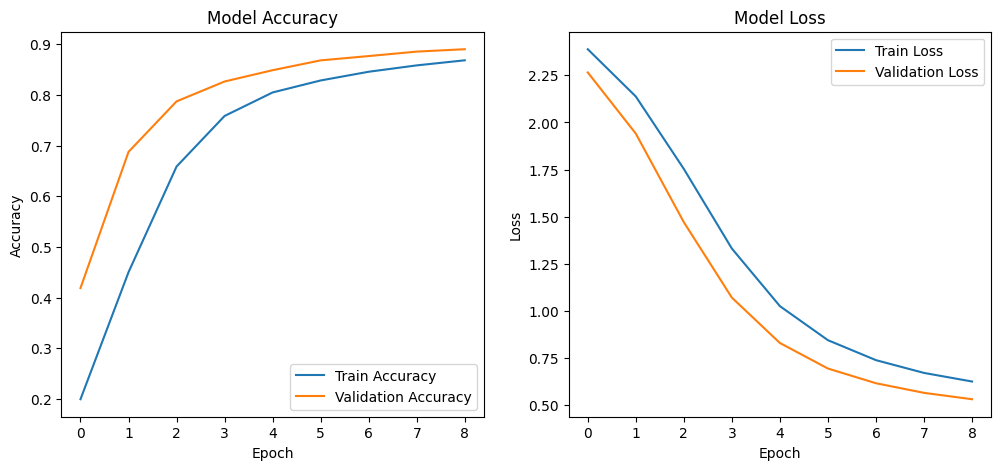

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_b4.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_b4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_fine_b4.history['loss'], label='Train Loss')
plt.plot(history_fine_b4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **WEAK CLASSES**

---

## Cat `label` is the weak class

Perhaps `Cat vs Dog` seems to be the worst classes where our model fights to predict well, we wanted to check better why it happens. We can assume that the resolution of the images is too poor and obviously it affects, the model for much complex it looks like, cannot learn enough patterns across the low-resolution photos.

In [36]:
# Data we need to check is:

X_test_pp, y_test_cat # we already have this

y_test_labels= np.argmax(y_test_cat, axis=1) # labels for y_test

y_pred_probs       # predictions of y_pred, we already have this
y_pred_labels=     np.argmax(y_pred_probs, axis=1) # pred for labels
y_pred_confidence= np.max(y_pred_probs, axis=1)    # pred CONFIDENCE level for predictions

The `cat` label is `3`

In [37]:
# We get the index where the label is 3 <cat> but the model fails to predict it
cat_mask= (y_test_labels == 3)
misclassified_cat_indices= np.where((cat_mask) & (y_pred_labels != 3))[0]

# and we print it
print(f"Cats on test: {np.sum(cat_mask)}")
print(f"Misclassified cats: {len(misclassified_cat_indices)}")
print(f"Accuracy on 'cat': {1 - len(misclassified_cat_indices)/np.sum(cat_mask):.2%}")

Cats on test: 1000
Misclassified cats: 207
Accuracy on 'cat': 79.30%


Perhaps dogs and deers also has some issues while predicting with the model, we want to see their pred levels too.

- The `deer` label is `4`
- The `dog` label is `5`

>It should be a good practice to store these labels as vars, but since we're lacking out of RAM, we input these values directly, sorry!

In [38]:
deer_mask= (y_test_labels == 4)
misclassified_deer_indices= np.where((deer_mask) & (y_pred_labels != 4))[0]

print(f"Deers on test: {np.sum(deer_mask)}")
print(f"Misclassified deers: {len(misclassified_deer_indices)}")
print(f"Accuracy on 'deer': {1 - len(misclassified_deer_indices)/np.sum(deer_mask):.2%}")

Deers on test: 1000
Misclassified deers: 92
Accuracy on 'deer': 90.80%


In [39]:
dog_mask= (y_test_labels == 5)
misclassified_dog_indices= np.where((dog_mask) & (y_pred_labels != 5))[0]

print(f"Dogs on test: {np.sum(dog_mask)}")
print(f"Misclassified dogs: {len(misclassified_dog_indices)}")
print(f"Accuracy on 'dog': {1 - len(misclassified_dog_indices)/np.sum(dog_mask):.2%}")

Dogs on test: 1000
Misclassified dogs: 107
Accuracy on 'dog': 89.30%


In [40]:
#<>! AI GENERATED CODE <>!
def show_misclassified_by_class(real_class_name, n=10):
  class_idx = class_names.index(real_class_name)
  real_mask = (y_test_labels == class_idx)
  misclassified_mask = (y_pred_labels != class_idx)
  indices = np.where(real_mask & misclassified_mask)[0]

  if len(indices) == 0:
    print(f"No hay errores encontrados para '{real_class_name}'.")
    return

  print(f"Mostrando {min(n, len(indices))} errores de '{real_class_name}' (de {len(indices)} totales).")

  plt.figure(figsize=(12, 6))
  for i, idx in enumerate(indices[:n]):
    plt.subplot(2, 5, i + 1)
    img = X_test_pp[idx].copy()
    if img.max() > 1.0:
      img = img / 255.0
    plt.imshow(img)
    true_label = class_names[class_idx]
    pred_label = class_names[y_pred_labels[idx]]
    prob = y_pred_confidence[idx]
    title = f"Real: {true_label}\nPred: {pred_label} ({prob:.2f})"
    plt.title(title, fontsize=9, color='red' if pred_label != true_label else 'green')
    plt.axis('off')

  plt.suptitle(f"Misclassified '{real_class_name}'", fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()


Mostrando 10 errores de 'cat' (de 207 totales).


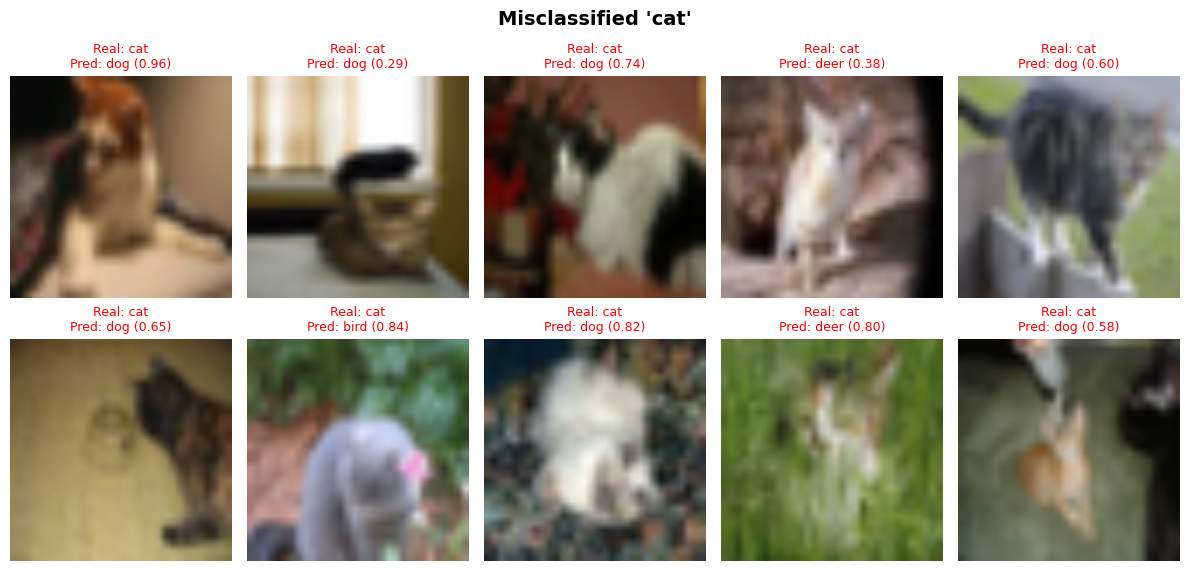

In [41]:
show_misclassified_by_class('cat', n=10)

Mostrando 10 errores de 'dog' (de 107 totales).


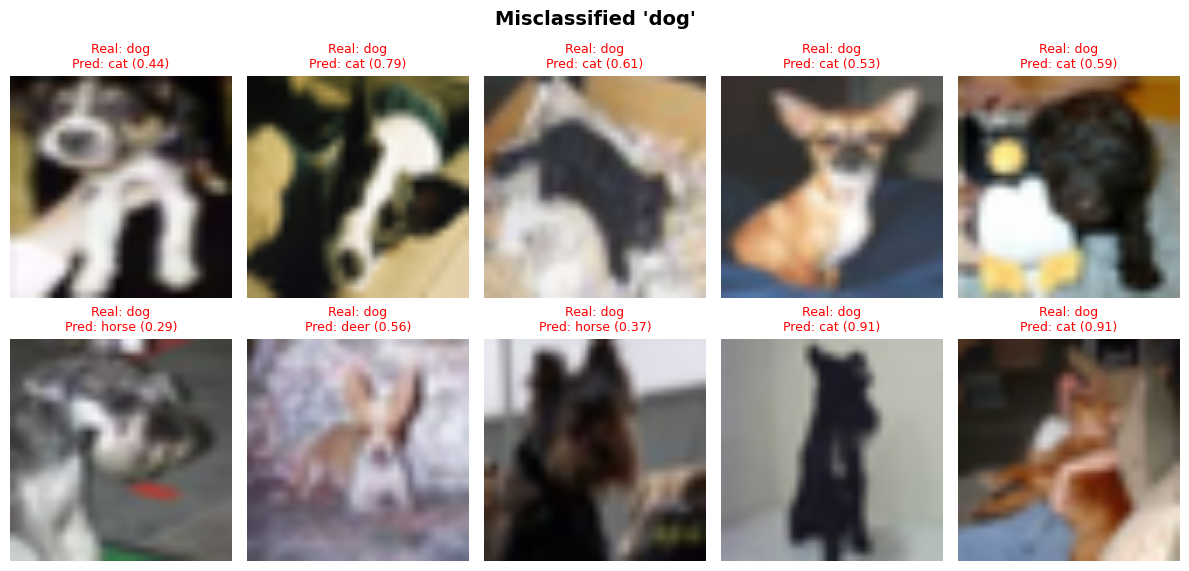

In [42]:
show_misclassified_by_class('dog', n=10)

Mostrando 10 errores de 'deer' (de 92 totales).


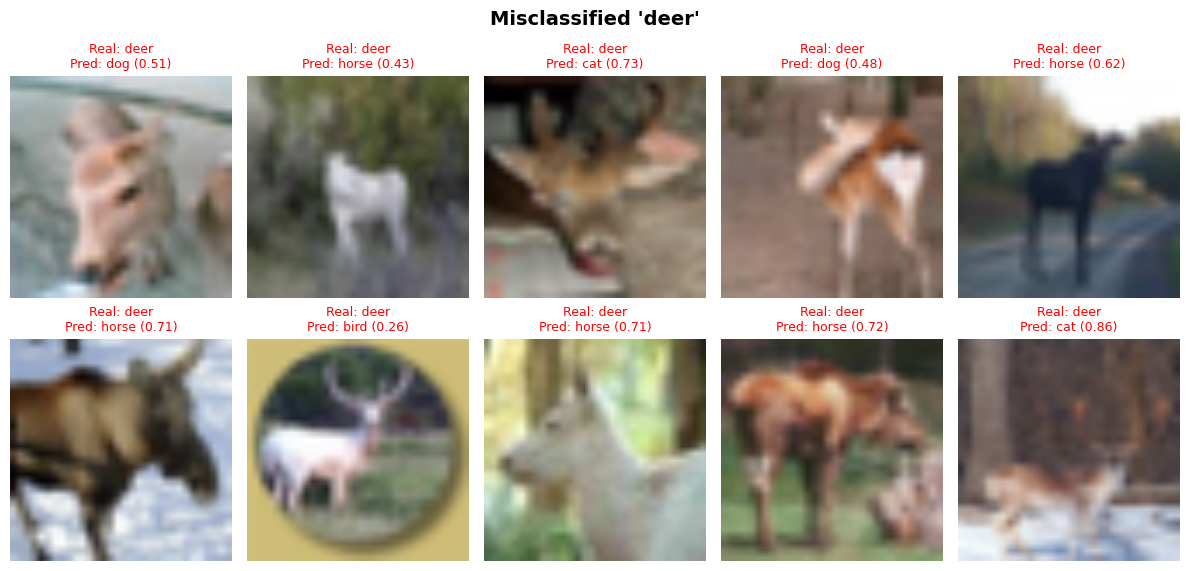

In [43]:
show_misclassified_by_class('deer', n=10)

# **WHAT TO DO NEXT**

## Problems

We have detected our problems:

- Dataset problems:
  - *CIFAR-10* has very low resolution per image.
  - Some samples are very hard for the model analysis comprehention.

- Model problems:
  - EfficientNetB2 is too complex.
  - EfficientNetB2 expects `224x224px` images.
  - Needs much computational power.
  - Resizing images waste a lot of RAM `+35GB RAM` for `158x158px`

- Predictions problems:
  - Weak classes `cat vs dog` and `deer`
  - Poor redability of the model on complex samples `cats`

## Dataset Problems

**CIFAR-10 image res:** We cannot do much here. The dataset is what it is, and expecting a higher results without data augmentation *wich requires a lot of computational power* would help to improve the results, but not too much using the model we're using here that also requires a lot of computational power.

**Hard samples:** We can do some focal-loss, renaming, resampling or even delete some of the samples that may confuse our model, but as we are working with tousands of samples, we are gonna need *much* more RAM.

## Model problems:

**EfficientNetB2 is too complex:** yes, it is, but is enough. We can also choose another model like B3 or B4 that handles good the images thanks to `imagenet`, but I choose B2 due to low complexity over other models the same family.

**EfficientNetB2 and 224x224px:** well, we can easily do that by just resizing the samples, but as the constant limitant, we need much more computational power.

## Prediction problems:

**Weak classes:** we saw `cat vs dog` is the most common problem for our model; we can treat this with some data augmentation —most common problem solving one. But, for this, we need much computational power in order to handle all images while keeping the resized images. Simply too much even for google collab, and `I` don't have the knowledge to do some `on-the-fly` processing of data.

**Poor redability:** can also be solved as said before; or renaming-deleting some samples that may confuse our model.